In [ ]:
##### Dependencies
import os
import keras
import tifffile
import tensorflow as tf
from keras import layers
from matplotlib import pyplot as plt
gpu_id = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
# read training images (already normalized) and convert image to ZXYC
path_data_encoder = "/mnt/local/data2/Bootsma/2D_CTC/src/analysis/publication_code/data/"
x_train = tifffile.imread(path_data_encoder+"02_train_CTC_classification_encoder.normalized.tiff").transpose(0,2,3,1) 

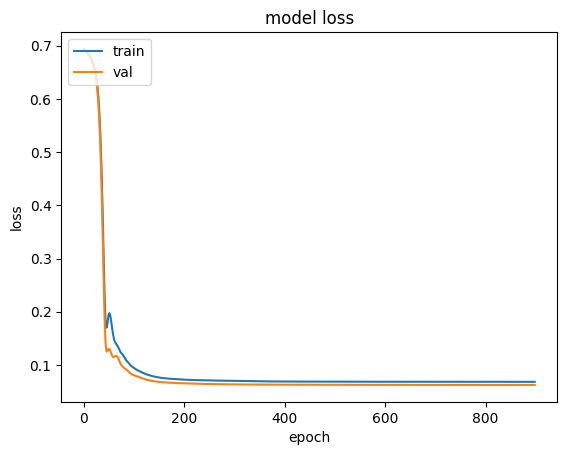

In [ ]:
#### build AE
with tf.device(f'/gpu:{gpu_id}'):  # Use the specified GPU

    #### CONV AE
    c = x_train.shape[3]
    input_img = keras.Input(shape=(x_train.shape[1:4]))
    # Encoder
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    # Final layer outputs c channels
    decoded = layers.Conv2D(c, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    ####
    encoder = keras.Model(input_img, encoded)

    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, mode = 'min', restore_best_weights= True)]
    history = autoencoder.fit(x_train, x_train, validation_split=0.2,
                    epochs=1000,
                    batch_size=512,      
                    callbacks=callbacks,
                    verbose = False
                    )

# review training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
